In [1]:
#FB Prophet
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

from prophet import Prophet


/Users/ag/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ag/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
def load_yf_data(ticker="^GSPC", period="10y"):
    data = yf.Ticker(ticker).history(period=period, interval="1d")
    return data

# Example usage
SPY_data = load_yf_data("^GSPC")        # S&P 500
DOW_data = load_yf_data("^DJI")         # Dow Jones
NASDAQ_data = load_yf_data("^IXIC")     # NASDAQ

In [4]:
def run_prophet_last_180_evaluation(data, ticker_label="Index", test_days=180):
    df_fb = data.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    df_fb['ds'] = df_fb['ds'].dt.tz_localize(None)

    # Split: last 180 days as test set
    train_df = df_fb[:-test_days]
    test_df = df_fb[-test_days:]

    model = Prophet(
    changepoint_prior_scale=0.3,       # more responsive to trend shifts
    seasonality_mode='multiplicative', # better for data with growth/decline
    seasonality_prior_scale=20,        # allow more flexibility
    changepoint_range=0.9              # find changepoints closer to the end
)
    model.fit(train_df)

    # Forecast only the test dates
    future = test_df[['ds']].copy()
    forecast = model.predict(future)

    # Evaluate only on the last 180 days
    forecast_eval = forecast[['ds', 'yhat']].reset_index(drop=True)
    actual_eval = test_df[['ds', 'y']].reset_index(drop=True)

    rmse = np.sqrt(mean_squared_error(actual_eval['y'], forecast_eval['yhat']))
    mae = mean_absolute_error(actual_eval['y'], forecast_eval['yhat'])
    r2 = r2_score(actual_eval['y'], forecast_eval['yhat'])

    print(f"Prophet Evaluation Metrics ({ticker_label}):")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(actual_eval['ds'], actual_eval['y'], label="Actual", linewidth=2)
    plt.plot(forecast_eval['ds'], forecast_eval['yhat'], label="Forecast", linestyle='--', color='darkorange')
    plt.title(f"{ticker_label} - Prophet Forecast vs Actual (Last 180 Days)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, forecast_eval, {'rmse': rmse, 'mae': mae, 'r2': r2}


03:53:48 - cmdstanpy - INFO - Chain [1] start processing
03:53:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet Evaluation Metrics (S&P 500):
RMSE: 387.6062
MAE:  277.1301
R² Score: -1.4494


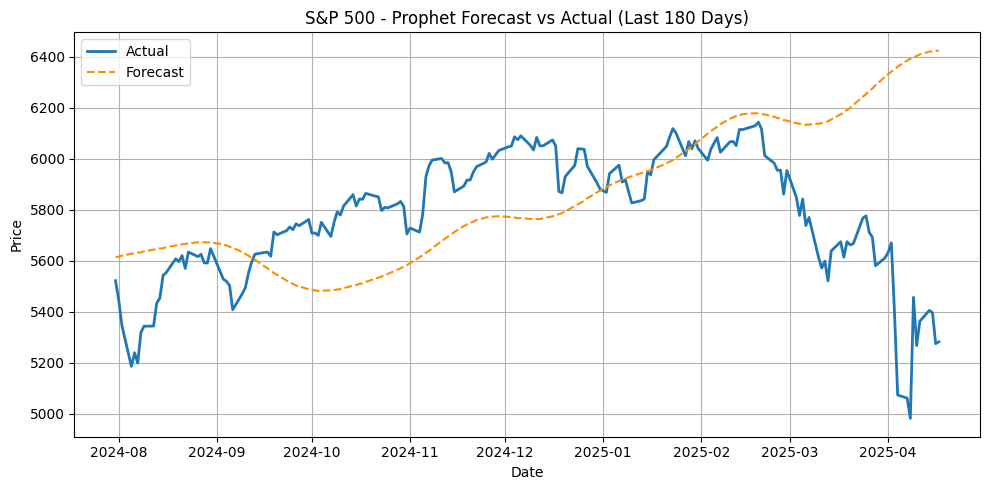

03:53:49 - cmdstanpy - INFO - Chain [1] start processing
03:53:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet Evaluation Metrics (Dow Jones):
RMSE: 2181.2656
MAE:  1717.0412
R² Score: -0.8332


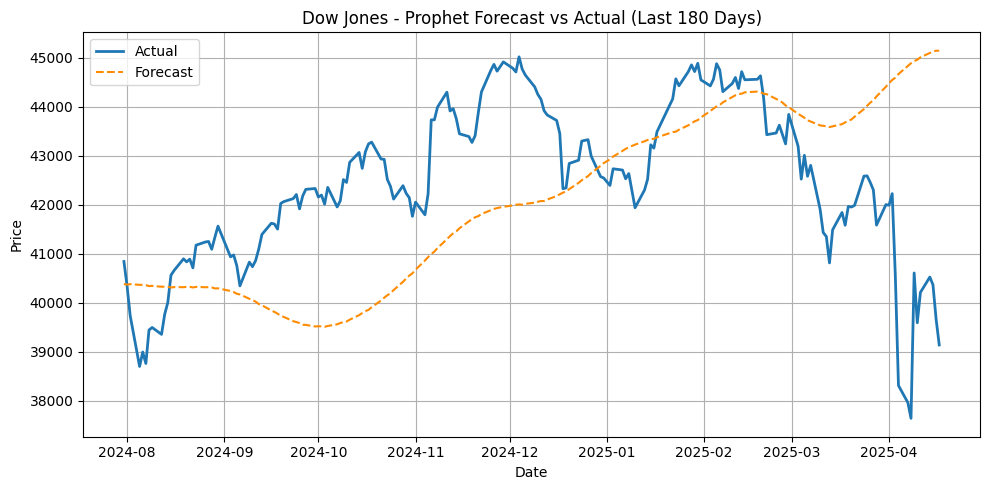

03:53:51 - cmdstanpy - INFO - Chain [1] start processing
03:53:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet Evaluation Metrics (NASDAQ):
RMSE: 1628.5122
MAE:  1109.8300
R² Score: -1.1612


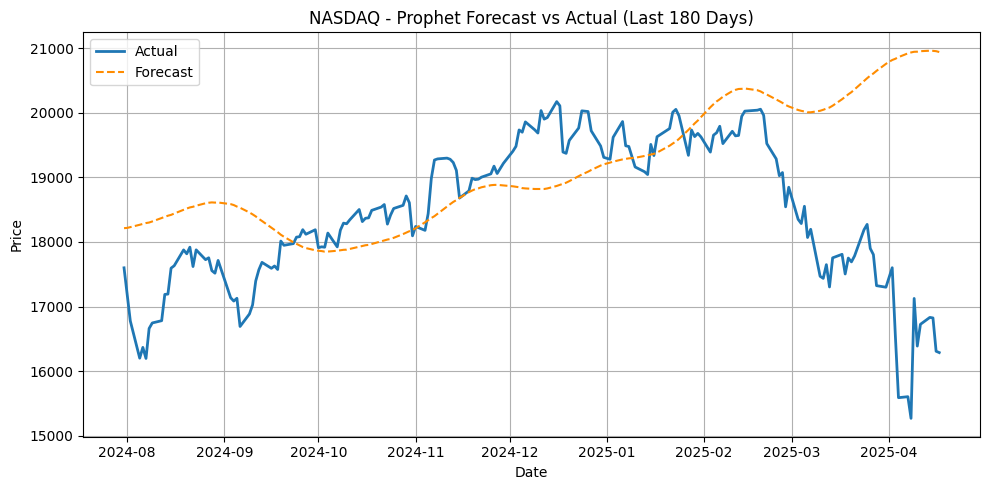

In [5]:
model_spy, forecast_spy, prophet_metrics_spy = run_prophet_last_180_evaluation(SPY_data, "S&P 500")
model_dow, forecast_dow, prophet_metrics_dow = run_prophet_last_180_evaluation(DOW_data, "Dow Jones")
model_nasdaq, forecast_nasdaq, prophet_metrics_nasdaq = run_prophet_last_180_evaluation(NASDAQ_data, "NASDAQ")


In [6]:
prophet_metrics_df = pd.DataFrame({
    'S&P 500': {
        'Prophet_RMSE': prophet_metrics_spy['rmse'],
        'Prophet_MAE': prophet_metrics_spy['mae'],
        'Prophet_R2': prophet_metrics_spy['r2'],
    },
    'Dow Jones': {
        'Prophet_RMSE': prophet_metrics_dow['rmse'],
        'Prophet_MAE': prophet_metrics_dow['mae'],
        'Prophet_R2': prophet_metrics_dow['r2'],
    },
    'NASDAQ': {
        'Prophet_RMSE': prophet_metrics_nasdaq['rmse'],
        'Prophet_MAE': prophet_metrics_nasdaq['mae'],
        'Prophet_R2': prophet_metrics_nasdaq['r2'],
    }
}).T.round(4)

In [7]:
prophet_metrics_df.style.set_caption("FB Prophet Model Performance Across Indexes (180-Day Test Window)")


,Prophet_RMSE,Prophet_MAE,Prophet_R2
S&P 500,387.606200,277.130100,-1.449400
Dow Jones,2181.265600,1717.041200,-0.833200
NASDAQ,1628.512200,1109.830000,-1.161200
